## bagging+bootstrap logistic model

In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from functools import reduce
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('/Users/jemma/Downloads/final result.csv')
df = df[df.columns[2:-1].to_list()]
X = df[df.columns[1:]].values
y = df['Mortality (1= death)'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [4]:
class LogisticRegressionClassifier:

    def __init__(self, n=100):
        self.n = n

    def fit(self, X, y, random_state=42, criterion='entropy'):
        X_train_p = X[y==1]
        X_train_n = X[y==0]
        y_train_p = y[y==1]
        y_train_n = y[y==0]
        l = sum(y_train_p)
        clf_list = []
        np.random.seed(seed=random_state)
        for i in range(self.n):
            idx_n = np.random.choice(range(X_train_n.shape[0]), l)
            idx_p = np.random.choice(range(X_train_p.shape[0]), l)
            X_train_f = np.concatenate([X_train_n[idx_n, :], X_train_p[idx_p]])
            y_train_f = np.concatenate([y_train_n[idx_n], y_train_p[idx_p]])
            clf = LogisticRegression()
            clf.fit(X_train_f, y_train_f)
            clf_list.append(clf)
            print(f'\rClassifier {i+1} completed.', end='')
        self.clfs = clf_list        
    
    def coefficients(self):
        feature_importance = abs(self.clfs[0].coef_)
        for tree in self.clfs[1:]:
            feature_importance += tree.coef_
        return feature_importance/ self.n
    
    def predict(self, X):
        result_list = list(map(lambda clf: clf.predict_proba(X)[:,1], self.clfs))
        score = reduce(lambda a, b: a+b, result_list) / len(self.clfs)
        return score
        
    def report(self, X, y):
        y_hat = self.predict(X)
        print(classification_report(y_test, 1.*(y_hat>0.5)))

In [5]:
btc = LogisticRegressionClassifier(1)
btc.fit(X_train, y_train)
y_hat = 1.0 * (btc.predict(X_test)>0.5)

Classifier 1 completed.

In [6]:
btc.coefficients()

array([[2.10598612e-01, 5.96824045e-01, 5.06187386e-01, 6.98488876e-02,
        1.72732876e-01, 1.14424978e+00, 4.69958948e-01, 1.24308110e-01,
        5.39905051e-01, 4.50232780e-01, 1.78666029e-01, 1.38006031e-01,
        3.19516663e-01, 6.94285442e-01, 7.90510238e-01, 7.99581711e-01,
        3.91811432e-01, 1.43413276e+00, 1.95429870e+00, 1.53205126e+00,
        7.81562483e-01, 5.48376872e-01, 2.79401678e-01, 1.25133795e+00,
        6.37731671e-03, 1.20442313e+00, 1.51901561e+00, 7.31409660e-01,
        1.66890152e+00, 1.09774900e+00, 4.18224217e-01, 2.00502955e+00,
        1.37184826e+00, 1.18748410e+00, 1.16277122e+00, 1.45111405e+00,
        1.27056674e+00, 1.53361490e+00, 3.33686838e+00, 1.05901520e+00,
        1.01357779e+00, 2.03867024e+00, 1.88779993e+00, 9.71722165e-01,
        1.31671282e+00, 1.71590240e+00, 5.03550052e-01, 1.22616452e+00,
        1.11507305e+00, 1.08136973e+00, 6.35599211e-01, 1.92617972e+00,
        1.18290467e+00, 1.14409924e+00, 2.22917830e-01, 1.087688

In [8]:
reshaped_cof = pd.DataFrame(btc.coefficients().reshape(-1,1))
predictors = pd.DataFrame(df.columns)
predictors_final = predictors.drop(predictors.index[0], axis=0)
predictors_final.index = np.arange(1,len(predictors_final)+1)
reshaped_cof.index =  np.arange(1,len(reshaped_cof)+1)

In [9]:
coefficient_tb1= pd.concat([predictors_final,reshaped_cof], axis=1, ignore_index=True)
coefficient_tb2 = coefficient_tb1.rename(columns={0: "Predictor", 1: "Coefficient"})
coefficient_tb_final = coefficient_tb2.sort_values(by=["Coefficient"],ascending=False)
coefficient_tb_final.head(10)
coefficient_tb_final.to_csv('coefficient_tb_final.csv')

In [22]:
print(classification_report(y_true=y_test, y_pred=y_hat))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     87390
           1       0.50      0.93      0.65      5269

    accuracy                           0.94     92659
   macro avg       0.75      0.94      0.81     92659
weighted avg       0.97      0.94      0.95     92659



In [11]:
f1_score(y_true=y_test, y_pred=y_hat)

0.6495376486129458

In [12]:
accuracy_score(y_true=y_test, y_pred=y_hat)

0.9427362695474806

In [13]:
confusion_matrix(y_true=y_test, y_pred=y_hat)

array([[82436,  4954],
       [  352,  4917]])

In [123]:
import matplotlib as mpl
import matplotlib.pyplot as plt
feature_importance = abs(coefficient_tb_final[coefficient_tb_final.columns[1]])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
score = feature_importance.head(10)
predictors_10 = coefficient_tb_final[coefficient_tb_final.columns[0]].head(10)
feature_importance_table = pd.concat([predictors_10,score], axis=1)
feature_importance_table
feature_importance_table_desc = feature_importance_table.sort_values(by=["Coefficient"],ascending=True)
feature_importance_table_desc

,Predictor,Coefficient
46,CVASC_Other_Nos_B,51.422538
102,FGENT_Screening,53.723175
43,CVASC_Heart_Rhythm_B,56.574000
52,CVASC_Venous_B,57.724174
19,CHEST_Airway_Lungs_B,58.566850
32,CHEST_Status_A,60.087163
42,CVASC_Heart_Rhythm_A,61.095315
66,ENDOC_MET_Diabetes,64.711634
63,DERMA_Whole_Body_Nos_B,83.043144
39,CVASC_Cardiac_B,100.000000


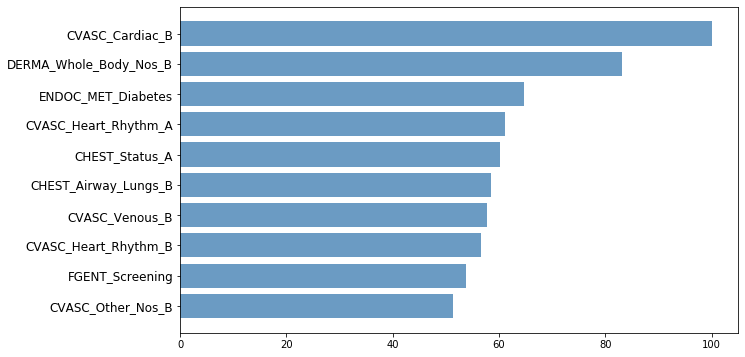

In [124]:
fig = plt.figure(figsize=(10,6))

share = feature_importance_table_desc[feature_importance_table_desc.columns[1]]
plt.barh(range(10), share, align = 'center',color='steelblue', alpha = 0.8)

plt.yticks(range(10),feature_importance_table_desc[feature_importance_table_desc.columns[0]], fontsize=12)
ax.set_xlabel('Relative Feature Importance (%)')

#plt.tight_layout()   
plt.show()